<a href="https://colab.research.google.com/github/atikaakter/Atika/blob/master/mnist_test_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import random
import shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [12]:
df=pd.read_csv('./sample_data/mnist_train.csv', header=None)
#

In [13]:
if os.path.exists("images"):
  shutil.rmtree("images")

os.makedirs("images")

In [14]:
image_arrays=df.to_numpy()
len(image_arrays)

1725

In [15]:
print(image_arrays.dtype)

float64


In [17]:
for img in image_arrays:
  filename = os.path.join('images', str(random.randint(100000000000,999999999999))+f'_{img[0]}.jpeg')
  Image.fromarray(np.uint8((np.reshape(img[1:], (28,28))))).save(filename)

773998477830_0.0.jpeg


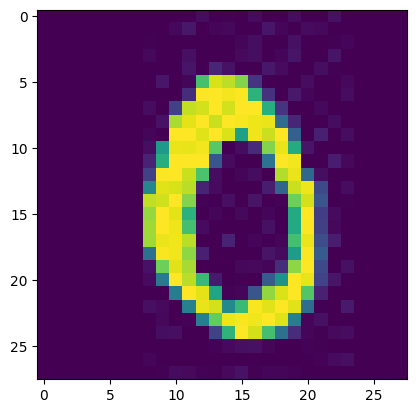

In [18]:
images=os.listdir('images')
n=62
print(images[n])
im=plt.imread(os.path.join('images',images[n]))
plt.imshow(im)     

In [19]:
def get_label(filenm):
  return filenm.split('.jpeg')[0].split('_')[1]

In [20]:
path = 'images'
for image in images:
  if not os.path.exists(os.path.join(path,get_label(image))):      
    os.makedirs(os.path.join(path,get_label(image)))  
  shutil.move(os.path.join(path,image),os.path.join(path, get_label(image),image))

In [21]:
tf.keras.preprocessing.image_dataset_from_directory(
	path,
	labels="inferred",
	label_mode="int",
	class_names=None,
	color_mode="rgb",
	batch_size=32,
	image_size=(256, 256),
	shuffle=True,
	seed=None,
	validation_split=None,
	subset=None,
	interpolation="bilinear",
	follow_links=False,
	crop_to_aspect_ratio=False,
)

Found 1725 files belonging to 10 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
   image_size=(256, 256),
  batch_size=32)

Found 1725 files belonging to 10 classes.
Using 1380 files for training.


In [23]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=32)

Found 1725 files belonging to 10 classes.
Using 345 files for validation.


In [24]:
class_names = train_ds.class_names
print(class_names)

['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']


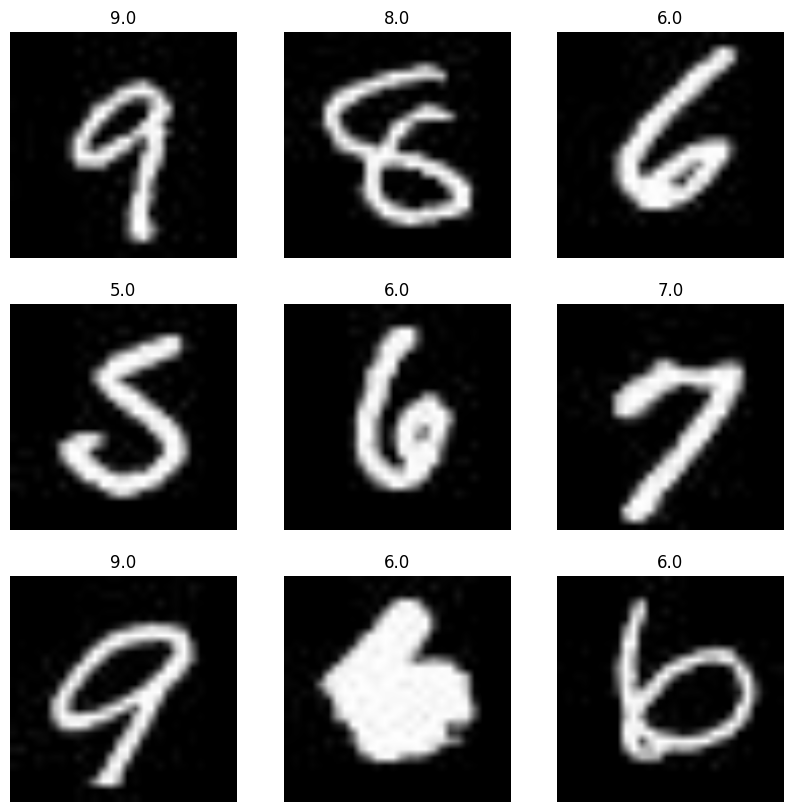

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [26]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256,256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(100, activation='relu'),
  layers.Dense(num_classes)
])

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       

In [38]:
epochs=3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
44/44 [==============================] - 129s 3s/step - loss: 0.8220 - accuracy: 0.7391 - val_loss: 0.4389 - val_accuracy: 0.8696
Epoch 2/3
44/44 [==============================] - 125s 3s/step - loss: 0.2579 - accuracy: 0.9217 - val_loss: 0.3518 - val_accuracy: 0.8928
Epoch 3/3
44/44 [==============================] - 117s 3s/step - loss: 0.1215 - accuracy: 0.9638 - val_loss: 0.4132 - val_accuracy: 0.8928


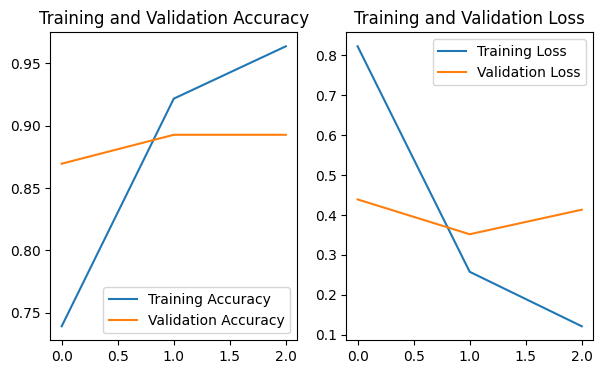

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [58]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(256,
                                  256,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

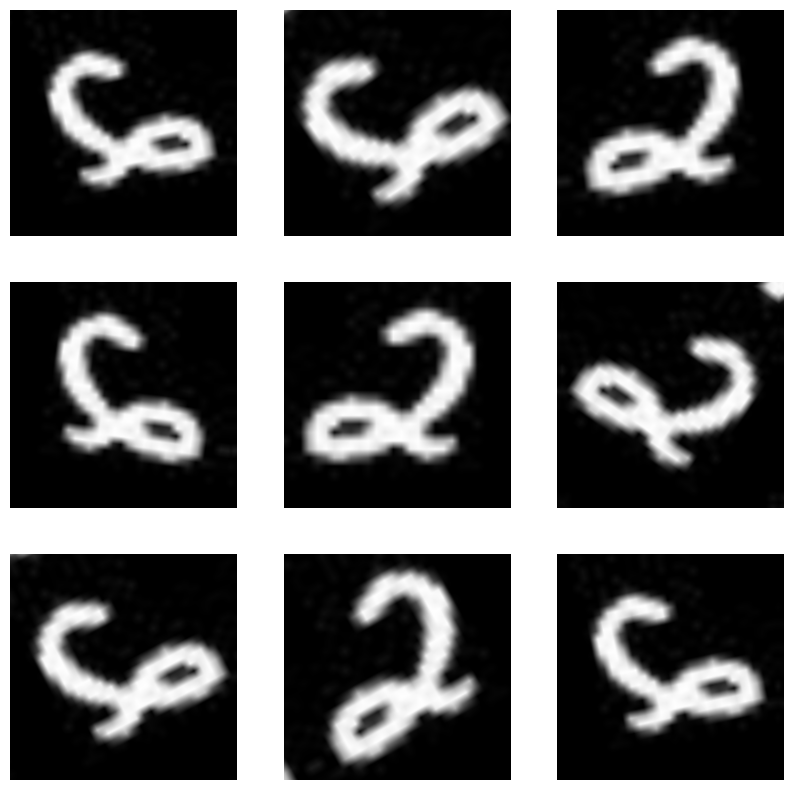

In [59]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [60]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(10, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [61]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [63]:
epochs = 3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
250/250 [==============================] - 715s 3s/step - loss: 1.0839 - accuracy: 0.6455 - val_loss: 0.5328 - val_accuracy: 0.8200
Epoch 2/3
250/250 [==============================] - 736s 3s/step - loss: 0.6033 - accuracy: 0.8001 - val_loss: 0.3546 - val_accuracy: 0.8800
Epoch 3/3
250/250 [==============================] - 687s 3s/step - loss: 0.4976 - accuracy: 0.8367 - val_loss: 0.3179 - val_accuracy: 0.8990


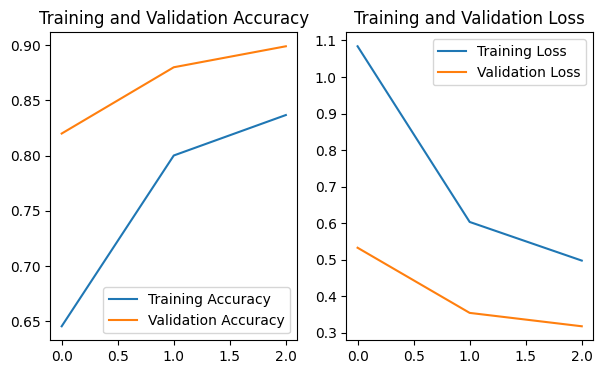

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()